In [1]:
class MT19937:
    w, n = 32, 624
    f = 1812433253
    m, r = 397, 31
    a = 0x9908B0DF
    d, b, c = 0xFFFFFFFF, 0x9D2C5680, 0xEFC60000
    u, s, t, l = 11, 7, 15, 18

    def __init__(self, seed):
        self.X = [0] * MT19937.n
        self.cnt = 0
        self.initialize(seed)

    def initialize(self, seed):
        self.X[0] = seed
        for i in range(1, MT19937.n):
            self.X[i] = (MT19937.f * (self.X[i - 1] ^ (self.X[i - 1] >> (MT19937.w - 2))) + i) & ((1 << MT19937.w) - 1)
        self.twist()

    def twist(self):
        for i in range(MT19937.n):
            lower_mask = (1 << MT19937.r) - 1
            upper_mask = (~lower_mask) & ((1 << MT19937.w) - 1)
            tmp = (self.X[i] & upper_mask) + (self.X[(i + 1) % MT19937.n] & lower_mask)
            tmpA = tmp >> 1
            if tmp % 2:
                tmpA = tmpA ^ MT19937.a
            self.X[i] = self.X[(i + MT19937.m) % MT19937.n] ^ tmpA
        self.cnt = 0

    def temper(self):
        if self.cnt == MT19937.n:
            self.twist()
        y = self.X[self.cnt]
        y = y ^ ((y >> MT19937.u) & MT19937.d)
        y = y ^ ((y << MT19937.s) & MT19937.b)
        y = y ^ ((y << MT19937.t) & MT19937.c)
        y = y ^ (y >> MT19937.l)
        self.cnt += 1
        return y & ((1 << MT19937.w) - 1)

    def normalize_values(self, numbers):
        min_value = min(numbers)
        max_value = max(numbers)
        normalized_values = [(value - min_value) / (max_value - min_value) for value in numbers]
        return normalized_values


In [3]:
import numpy as np
from scipy.stats import kstest
import matplotlib.pyplot as plt


class Test:
    def __init__(self, data):
        self.data = data

    def kolmogorov_smirnov_test(self, alpha=0.05):
        # Проверка на равномерность на интервале от 0 до 1
        D, p_value = kstest(self.data, 'uniform')

        if p_value > alpha:
            print(f'Выборка следует равномерному распределению (p-value={p_value: .4f})')
        else:
            print(f'Выборка не следует равномерному распределению (p-value={p_value: .4f})')

        # Построение гистограммы и кумулятивной функции распределения
        fig, ax = plt.subplots(figsize=(10, 6))

        n_bins = int(np.sqrt(len(self.data)))
        ax.hist(self.data, bins=n_bins, density=True, label='Гистограмма', color='skyblue', edgecolor='black')

        ax.set_xlabel('Значение')
        ax.set_ylabel('Плотность вероятности')
        ax.legend()

        plt.title(f'Тест Колмогорова-Смирнова (p-value={p_value:.4f})')
        plt.show()

    # Порт представленного в видео теста на язык Python ради интереса
    def cpp_test_port(self, m, alpha):
        RN_arr = self.data
        n = len(RN_arr)

        frec = np.zeros(m, dtype=int)
        abs_diff = np.zeros(m, dtype=float)

        obs_distrib = 0
        sub_seg_len = 1.0 / m
        H0Acc = 1

        if alpha >= 0.1:
            DaN = 1.22 / np.sqrt(n)
        elif alpha > 0.05:
            DaN = 1.36 / np.sqrt(n)
        else:
            DaN = 1.63 / np.sqrt(n)

        print(f"Specified alpha = {alpha:.2f}. The critical value is {DaN:.4f}. Numbers of net's segments: {m}\n")

        for i in range(n):
            SegN = min(int(RN_arr[i] * m), m - 1)
            frec[SegN] += 1

        print("The observed frequencies:")
        print(frec)

        for i in range(m):
            obs_distrib += float(frec[i]) / n
            print(
                f"Subsegment: {i}. Observed distribution: {obs_distrib:.6f}, theoretical distribution {sub_seg_len * (i + 1): .6f}, the difference: {abs(obs_distrib - sub_seg_len * (i + 1)): .6f}.")
            abs_diff[i] = abs(obs_distrib - sub_seg_len * (i + 1))

        CDaN = abs_diff[np.argmax(abs_diff)]
        print(f"Maximum of differences: {CDaN:.6f}, critical value: {DaN:.6f}.\n")

        if DaN <= abs_diff[np.argmax(abs_diff)]:
            H0Acc = 0
        return H0Acc

Тестирование алгоритма Вихрь Мерсена
Выборка следует равномерному распределению (p-value= 0.8891)


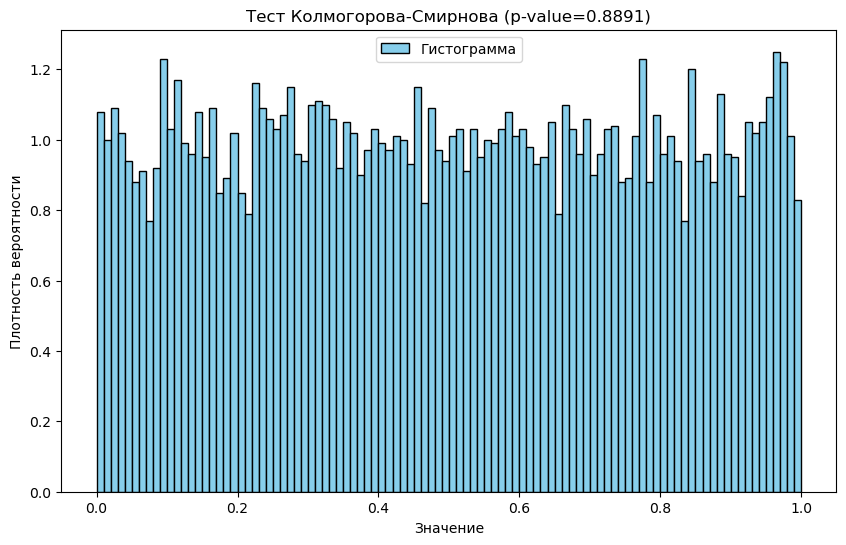



Тестирование библиотеки random
Выборка следует равномерному распределению (p-value= 0.1018)


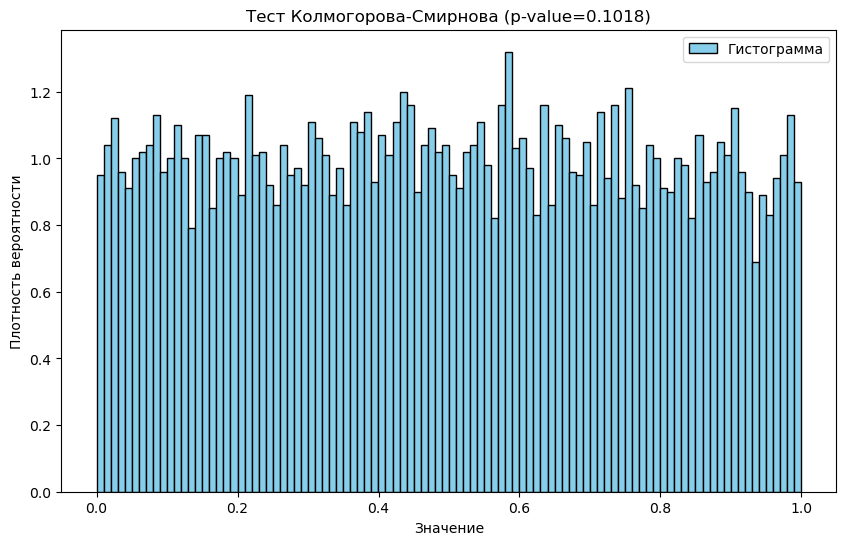



Импортированный тест на C++ из видео
Specified alpha = 0.06. The critical value is 0.0136. Numbers of net's segments: 10

The observed frequencies:
[ 984 1003 1010 1026  987 1004  988  989  975 1034]
Subsegment: 0. Observed distribution: 0.098400, theoretical distribution  0.100000, the difference:  0.001600.
Subsegment: 1. Observed distribution: 0.198700, theoretical distribution  0.200000, the difference:  0.001300.
Subsegment: 2. Observed distribution: 0.299700, theoretical distribution  0.300000, the difference:  0.000300.
Subsegment: 3. Observed distribution: 0.402300, theoretical distribution  0.400000, the difference:  0.002300.
Subsegment: 4. Observed distribution: 0.501000, theoretical distribution  0.500000, the difference:  0.001000.
Subsegment: 5. Observed distribution: 0.601400, theoretical distribution  0.600000, the difference:  0.001400.
Subsegment: 6. Observed distribution: 0.700200, theoretical distribution  0.700000, the difference:  0.000200.
Subsegment: 7. Observ

In [5]:
from mersenne_tempest import MT19937
from test import Test
import random

def main():
    rng = MT19937(0)
    data = []
    for i in range(10000):
        data.append(rng.temper())
    data = rng.normalize_values(data)
    print('Тестирование алгоритма Вихрь Мерсена')
    test_unit = Test(data)
    test_unit.kolmogorov_smirnov_test()

    lib_data = []
    for i in range(10000):
        lib_data.append(random.random())
    print('\n\nТестирование библиотеки random')
    test_lib_unit = Test(lib_data)
    test_lib_unit.kolmogorov_smirnov_test()

    print('\n\nИмпортированный тест на C++ из видео')
    hypothesis = test_unit.cpp_test_port(10, 0.06)
    if hypothesis == 1:
        print('Импортированный тест подтверждает гипотезу о равномерности')
    else:
        print('Импортированный тест опровергает гипотезу о равномерности')

if __name__ == '__main__':
    main()

